In [172]:
%store -r stats area_downwind_km2 area_upwind_km2 area_urban_km2 urban_radius city_center clipped_urban_circle clipped_downwind_wedge clipped_upwind_wedge topoZ topoLon topoLat


In [173]:
import numpy as np
import xarray as xr
from shapely.geometry import Point
import matplotlib as mpl

In [174]:
# Read cell tracking data
time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Find tracks where initiation longitude is not NaN
# These tracks are problematic and should be excluded
ind = np.where(~np.isnan(cell_lon0))[0]

# Subset the tracks
stats = stats.isel(tracks=ind).load()
ntracks = stats.dims['tracks']
print(f'Number of valid tracks: {ntracks}')


tracks = stats['tracks']
times = stats['times']

lifetime = stats['track_duration'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['max_dbz']
eth20 = stats['maxETH_20dbz']

Number of valid tracks: 21727


### Obtain cell start and end locations

In [175]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=float)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

### Find merge/split tracks

In [176]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 17793
Number of non-split tracks: 17927
Number of non-split tracks within max range: 0
Number of non-merge tracks within max range: 0
Number of merge tracks: 3934
Number of split tracks: 3800


In [177]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)

hist_starthour, bins = np.histogram(start_hour, bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour, bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)


# Convert to local time (UTC-5)
hist_starthour_LT = np.roll(hist_starthour, -5)
hist_starthour_in_LT = np.roll(hist_starthour_in, -5)

hist_endhour_LT = np.roll(hist_endhour, -5)
hist_endhour_in_LT = np.roll(hist_endhour_in, -5)

In [178]:
hist_starthour_LT

array([ 383,  530,  634,  757,  881,  954, 1049, 1065, 1033, 1187, 1333,
       1500, 1455, 1502, 1607, 1441, 1232,  870,  573,  448,  473,  272,
        235,  313], dtype=int64)

In [179]:
hour_bin[:-1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

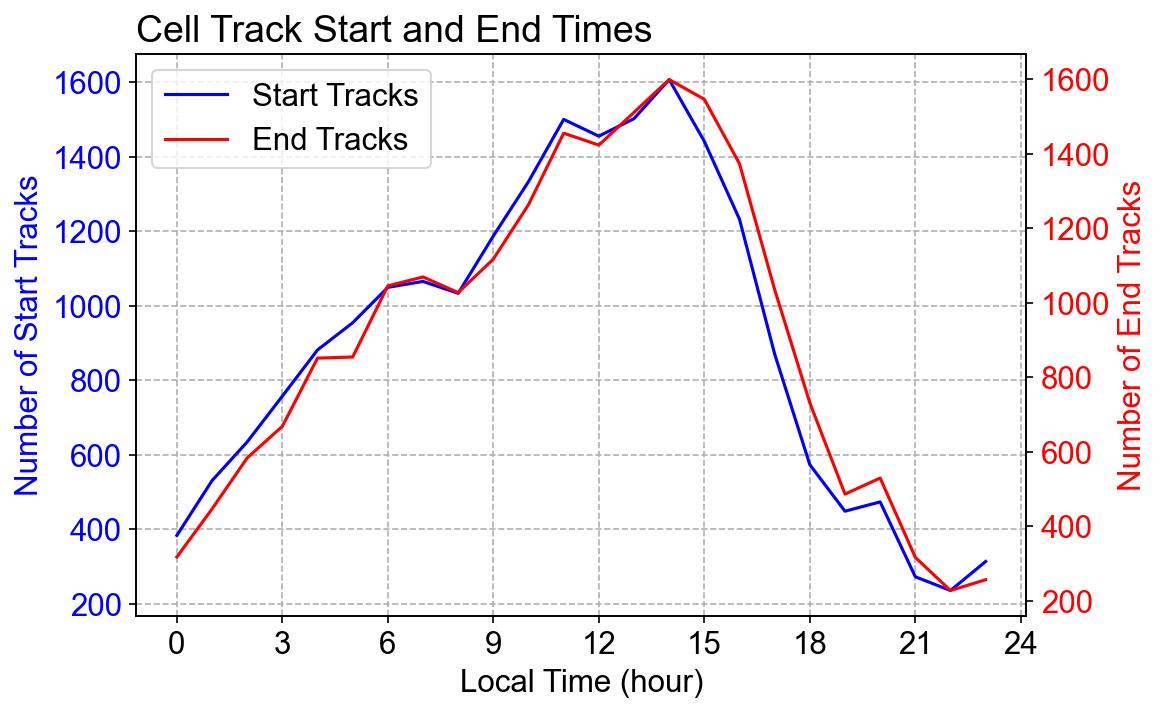

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Arial'
fig, ax1 = plt.subplots(figsize=(8,5), dpi=150)

# Plotting for cell track start times on the first y-axis
line1, = ax1.plot(hour_bin[:-1], hist_starthour_LT, label='Start Tracks', color='b')
ax1.set_xlabel('Local Time (hour)')
ax1.set_ylabel('Number of Start Tracks', color='b')
ax1.tick_params(axis='y', labelcolor='b')
#ax1.set_xlim(left=0.7)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.grid(ls='--')
ax1.set_title('Cell Track Start and End Times', loc='left')

# Setting up the second y-axis for cell track end times
ax2 = ax1.twinx()
line2, = ax2.plot(hour_bin[:-1], hist_endhour_LT, label='End Tracks', color='r')
ax2.set_ylabel('Number of End Tracks', color='r')
#ax2.set_xticks(np.arange(,24.1,3))
ax2.tick_params(axis='y', labelcolor='r')
#ax2.grid(ls='--')

# Creating a single legend inside the plot area
ax1.legend(handles=[line1, line2], loc='upper left')

fig.tight_layout()
plt.show()


# Plot heatmaps

In [181]:
# Get cell statistics variables
tracks = stats['tracks']
times = stats['times']

lifetime = stats['track_duration'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
core_area = stats['core_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['max_dbz']
eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']


In [182]:
start_hour

<xarray.DataArray 'hour' (tracks: 21727)>
array([ 0,  0,  0, ..., 22, 23, 23], dtype=int64)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 25329 25330 25331 25332 25333 25334
Attributes:
    long_name:  Start Epoch time of each track

In [183]:
# Count tracks by diurnal tracking


# Get initiation and time
hour_bin = np.arange(0, 25, 1)

hist_starthour, bins = np.histogram(start_hour, bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour, bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Initiation E.SDC vs. W.SDC
lon_SDC = -65
hist_starthour_eSDC, bins = np.histogram(start_hour.where(start_lon > lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)
hist_starthour_wSDC, bins = np.histogram(start_hour.where(start_lon <= lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-3)
hist_starthour_LT = np.roll(hist_starthour, -5)
hist_starthour_in_LT = np.roll(hist_starthour_in, -5)

hist_endhour_LT = np.roll(hist_endhour, -3)
hist_endhour_in_LT = np.roll(hist_endhour_in, -3)

hist_starthour_eSDC_LT = np.roll(hist_starthour_eSDC, -3)
hist_starthour_wSDC_LT = np.roll(hist_starthour_wSDC, -3)

# Fraction of E.SDC tracks to all tracks
hist_starthour_eSDC_LT_frac = 100 * (hist_starthour_eSDC_LT / hist_starthour_LT)

In [184]:
radar_lat = 29.4719
radar_lon = -95.0787

In [185]:
def plot_2heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, cblabels, titles, figname, eSDC=None):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Arial'
    fig, axes = plt.subplots(1, 2, figsize=(15,6), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [20,40,60,80,100]

    ax1 = axes[0]
    Zm = np.ma.masked_where(dataarr[0] == 0, dataarr[0])
    cmap = plt.get_cmap(cmaps[0])
    norm = mpl.colors.BoundaryNorm(boundaries=levels[0], ncolors=cmap.N)
    p1 = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p1, ax=ax1, label=cblabels[0])
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(titles[0], loc='left')
    ax1.set_xlim(np.min(lonarr), np.max(lonarr))
    ax1.set_ylim(np.min(latarr), np.max(latarr))
    ax1.set_xlim(np.min(lonarr), np.max(lonarr))
    ax1.set_ylim(np.min(latarr), np.max(latarr))
    ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax1.plot(radar_lon, radar_lat, **marker_style)
    ax1.grid(ls='--')
    if eSDC is not None:
        ax1.axvline(x=eSDC, color='magenta', lw=2)

    ax2 = axes[1]
    Zm = np.ma.masked_where(dataarr[1] == 0, dataarr[1])
    cmap = plt.get_cmap(cmaps[1])
    norm = mpl.colors.BoundaryNorm(boundaries=levels[1], ncolors=cmap.N)
    p2 = ax2.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p2, ax=ax2, label=cblabels[1])
    ax2.set_xlabel('Longitude')
#     ax2.set_ylabel('Latitude')
    ax2.set_title(titles[1], loc='left')
    ax2.set_xlim(np.min(lonarr), np.max(lonarr))
    ax2.set_ylim(28.6, np.max(latarr))
    ax2.set_xlim(np.min(lonarr), np.max(lonarr))
    ax2.set_ylim(np.min(latarr), np.max(latarr))
    ax2.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax2.plot(radar_lon, radar_lat, **marker_style)
    ax2.grid(ls='--')
    if eSDC is not None:
        ax2.axvline(x=eSDC, color='magenta', lw=2)

    fig.tight_layout()
    # fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

In [186]:
# city_center = (-95.43207102398061, 29.4719)

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches

def plot_2heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, city_center, urban_radius, cblabels, titles, figname, eSDC=None):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Arial'
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=150)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [20, 40, 60, 80, 100]

    city_center = city_center
    urban_radius = urban_radius
    downwind_start = 100
    downwind_end = 100
    sector_angle = 160  # in degrees
    mean_wind_angle = 125.37  # in degrees
    downwind_start_scaled = downwind_start * urban_radius / 25
    downwind_end_scaled = downwind_end * urban_radius / 25

    for ax in axes:
        Zm = np.ma.masked_where(dataarr[axes.tolist().index(ax)] == 0, dataarr[axes.tolist().index(ax)])
        cmap = plt.get_cmap(cmaps[axes.tolist().index(ax)])
        norm = mpl.colors.BoundaryNorm(boundaries=levels[axes.tolist().index(ax)], ncolors=cmap.N)
        p = ax.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
        cb = plt.colorbar(p, ax=ax, label=cblabels[axes.tolist().index(ax)])
        ax.set_xlabel('Longitude')
        if ax == axes[0]:
            ax.set_ylabel('Latitude')
        ax.set_title(titles[axes.tolist().index(ax)], loc='left')
        ax.set_xlim(np.min(lonarr), -94.1)
        ax.set_ylim(28.6, np.max(latarr))
        ax.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
        # ax.plot(radar_lon, radar_lat, **marker_style)
        ax.grid(ls='--')
        if eSDC is not None:
            ax.axvline(x=eSDC, color='magenta', lw=2)

        # Urban and impact area plotting
        urban_circle = patches.Circle(city_center, urban_radius, fill=False, alpha=0.5)
        ax.add_patch(urban_circle)
        # Adjust the following patches as necessary to fit your plotting context
        upwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle+180-(sector_angle/2), mean_wind_angle+180+(sector_angle/2), 
                             width=downwind_end_scaled - urban_radius, alpha=0.5, fill=False)
        ax.add_patch(upwind_wedge)

        downwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle-(sector_angle/2), mean_wind_angle+(sector_angle/2), width=downwind_end_scaled - urban_radius, fill=False, alpha=0.5)
        ax.add_patch(downwind_wedge)
        # Add other patches as needed following the same pattern

    fig.tight_layout()
    # Uncomment the next line to save the figure
    # fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig


In [188]:
np.nanmax(maxlat)

30.50552444458008

In [189]:
buffer = 0.05
minlon, maxlon = np.nanmin([start_lon.values, end_lon])-buffer, np.nanmax([start_lon.values, end_lon])+buffer
minlat, maxlat = np.nanmin([start_lat.values, end_lat])-buffer, np.nanmax([start_lat.values, end_lat])+buffer
print(minlon, maxlon, minlat, maxlat)

bins = [20, 20]
ranges = [[minlon+buffer,maxlon-buffer], [minlat+buffer,maxlat-buffer]]

hist2d_startloc, xbins, ybins = np.histogram2d(start_lon.values, start_lat.values, bins=bins, range=ranges)
hist2d_endloc, xbins, ybins = np.histogram2d(end_lon, end_lat, bins=bins, range=ranges)

hist2d_startloc = hist2d_startloc.transpose()
hist2d_endloc = hist2d_endloc.transpose()

-96.26935272216797 -93.88798065185547 28.43370361328125 30.50552444458008


In [190]:
hist2d_startloc_nonsplit, xbins, ybins = np.histogram2d(start_lon.values[nonsplit_in], start_lat.values[nonsplit_in], bins=bins, range=ranges)
hist2d_endloc_nonmerge, xbins, ybins = np.histogram2d(end_lon[nonmerge_in], end_lat[nonmerge_in], bins=bins, range=ranges)

hist2d_startloc_nonsplit = hist2d_startloc_nonsplit.transpose()
hist2d_endloc_nonmerge = hist2d_endloc_nonmerge.transpose()

In [191]:
hist2d_startloc_split, xbins, ybins = np.histogram2d(start_lon.values[split], start_lat.values[split], bins=bins, range=ranges)
hist2d_endloc_merge, xbins, ybins = np.histogram2d(end_lon[merge], end_lat[merge], bins=bins, range=ranges)

hist2d_startloc_split = hist2d_startloc_split.transpose()
hist2d_endloc_merge = hist2d_endloc_merge.transpose()

In [192]:
end_lon_eSDC = end_lon[np.where(start_lon > lon_SDC)]
end_lat_eSDC = end_lat[np.where(start_lon > lon_SDC)]
hist2d_endloc_eSDC, xbins, ybins = np.histogram2d(end_lon_eSDC, end_lat_eSDC, bins=bins, range=ranges)
hist2d_endloc_eSDC = hist2d_endloc_eSDC.transpose()

end_lon_wSDC = end_lon[np.where(start_lon <= lon_SDC)]
end_lat_wSDC = end_lat[np.where(start_lon <= lon_SDC)]
hist2d_endloc_wSDC, xbins, ybins = np.histogram2d(end_lon_wSDC, end_lat_wSDC, bins=bins, range=ranges)
hist2d_endloc_wSDC = hist2d_endloc_wSDC.transpose()

In [193]:
xbins

array([-96.21935272, -96.10528412, -95.99121552, -95.87714691,
       -95.76307831, -95.6490097 , -95.5349411 , -95.4208725 ,
       -95.30680389, -95.19273529, -95.07866669, -94.96459808,
       -94.85052948, -94.73646088, -94.62239227, -94.50832367,
       -94.39425507, -94.28018646, -94.16611786, -94.05204926,
       -93.93798065])

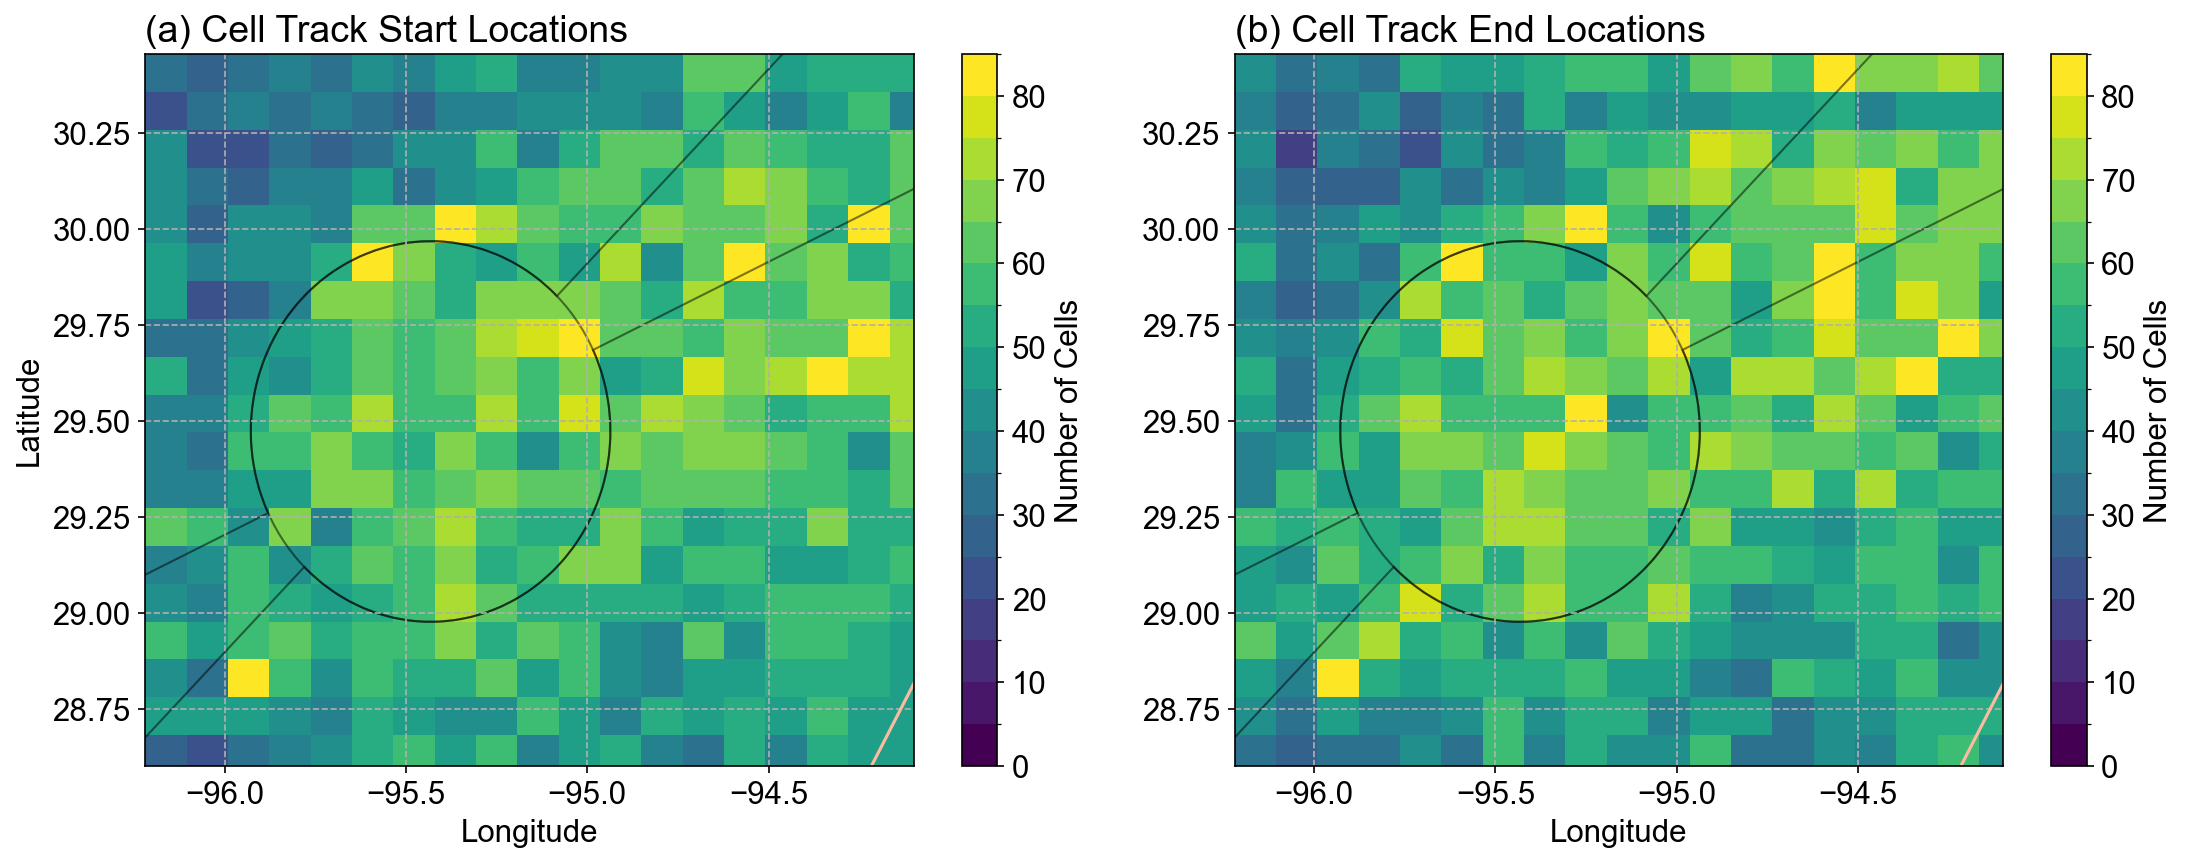

In [194]:
dataarr = [hist2d_startloc, hist2d_endloc]
levels = [np.arange(0, 85.1, 5), np.arange(0, 85.1, 5)]
cmap = ['viridis', 'viridis']
cmap_topo = 'Reds'
titles = ['(a) Cell Track Start Locations', '(b) Cell Track End Locations']
cblabels = ['Number of Cells', 'Number of Cells']
figname = f'celltrack_startend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, city_center, urban_radius, cblabels, titles, figname)


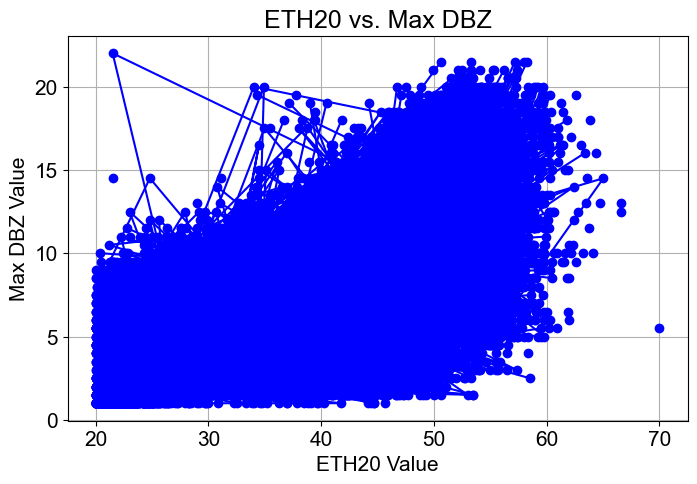

In [195]:
plt.figure(figsize=(8, 5))
plt.plot(maxdbz, eth20, marker='o', linestyle='-', color='blue')
plt.xlabel('ETH20 Value')
plt.ylabel('Max DBZ Value')
plt.title('ETH20 vs. Max DBZ')
plt.grid(True)
plt.show()

# Calculate mean/max cell statistics by locations

In [196]:
# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
hist2d_startloc_02deg, yy, xx = np.histogram2d(start_lat, start_lon, bins=[latbins, lonbins])
hist2d_endloc_02deg, yy, xx = np.histogram2d(end_lat, end_lon, bins=[latbins, lonbins])

Mean_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Samples_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_dbz_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_dbz_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_dbz_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Samples_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat = np.array(cell_lon).flatten()
Lat_flat = np.array(cell_lat).flatten()
Area_flat = np.array(cell_area).flatten()
ETH20_flat = np.array(eth20).flatten()
dbz_flat = np.array(maxdbz).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat >= lonbins[i], Lon_flat < lonbins[i]+lonbinsize),
                              Lat_flat >= latbins[j]), Lat_flat < latbins[j]+latbinsize), Area_flat > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Area_heatmap[j,i] = np.nanmean(Area_flat[mask])
            Median_Area_heatmap[j,i] = np.nanmedian(Area_flat[mask])
            Max_Area_heatmap[j,i] = np.nanmax(Area_flat[mask])
            Mean_ETH20_heatmap[j,i] = np.nanmean(ETH20_flat[mask])
            Median_ETH20_heatmap[j,i] = np.nanmedian(ETH20_flat[mask])
            Max_ETH20_heatmap[j,i] = np.nanmax(ETH20_flat[mask])
            Mean_ETH30_7km_heatmap[j,i] = np.nanmean(ETH30_gt7km_flat[mask])
            Mean_dbz_heatmap[j,i] = np.nanmean(dbz_flat[mask])
            Median_dbz_heatmap[j,i] = np.nanmedian(dbz_flat[mask])
            Max_dbz_heatmap[j,i] = np.nanmax(dbz_flat[mask])
            


C:\Users\omitu\AppData\Local\Temp\ipykernel_21892\3503790286.py:53: RuntimeWarning: Mean of empty slice
  Mean_ETH30_7km_heatmap[j,i] = np.nanmean(ETH30_gt7km_flat[mask])


In [197]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches

def plot_3heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, city_center, urban_radius, cblabels, cbticks, titles, xlabels, ylabels, figname, eSDC=None):
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Arial'
    fig, axes = plt.subplots(1, 3, figsize=(19, 5), dpi=150)  # Adjusted for 1 row, 3 columns
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500, 1000, 1500, 2000, 2500]

    city_center = city_center
    urban_radius = urban_radius
    downwind_start = 100
    downwind_end = 100
    sector_angle = 160  # in degrees
    mean_wind_angle = 125.37  # in degrees
    downwind_start_scaled = downwind_start * urban_radius / 25
    downwind_end_scaled = downwind_end * urban_radius / 25

    for col in range(3):  # Loop over columns for 3 heatmaps
        ax = axes[col]
        Zm = np.ma.masked_where(dataarr[col] == 0, dataarr[col])
        cmap = plt.get_cmap(cmaps[col])
        norm = mpl.colors.BoundaryNorm(boundaries=levels[col], ncolors=cmap.N)
        p1 = ax.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap, shading='auto')
        cb = plt.colorbar(p1, ax=ax, label=cblabels[col], ticks=cbticks[col])
        ax.set_xlabel(xlabels[col])
        ax.set_ylabel(ylabels[col])
        ax.set_title(titles[col], loc='left')
        ax.set_xlim(np.min(lonarr), -94.1)
        ax.set_ylim(28.6, np.max(latarr))
        ax.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo[col], linewidths=1.5)
        ax.grid(ls='--')
        if eSDC is not None:
            ax.axvline(x=eSDC, color='magenta', lw=2)

        # Urban and impact area plotting
        urban_circle = patches.Circle(city_center, urban_radius, fill=False, alpha=0.5)
        ax.add_patch(urban_circle)
        upwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle+180-(sector_angle/2), mean_wind_angle+180+(sector_angle/2), 
                             width=downwind_end_scaled - urban_radius, alpha=0.5, fill=False)
        ax.add_patch(upwind_wedge)
        downwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle-(sector_angle/2), mean_wind_angle+(sector_angle/2), width=downwind_end_scaled - urban_radius, fill=False, alpha=0.5)
        ax.add_patch(downwind_wedge)

    fig.tight_layout()
    # fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

# Note: You'll need to ensure that the variables `dataarr`, `lonarr`, `latarr`, `topoZ`, `topoLon`, `topoLat`, `levels`, `cmaps`, `cmap_topo`, `city_center`, `urban_radius`, `cblabels`, `cbticks`, `titles`, `xlabels`, `ylabels`, `figname`, and `eSDC` (if used) are properly defined before calling this function.


In [198]:
len(np.ma.masked_where(dataarr[1] == 0, dataarr[1]))

20

In [199]:
latbins

array([28.38370361, 28.51370361, 28.64370361, 28.77370361, 28.90370361,
       29.03370361, 29.16370361, 29.29370361, 29.42370361, 29.55370361,
       29.68370361, 29.81370361, 29.94370361, 30.07370361, 30.20370361,
       30.33370361, 30.46370361])

In [200]:
np.nanmin(Max_ETH20_heatmap)

8.5

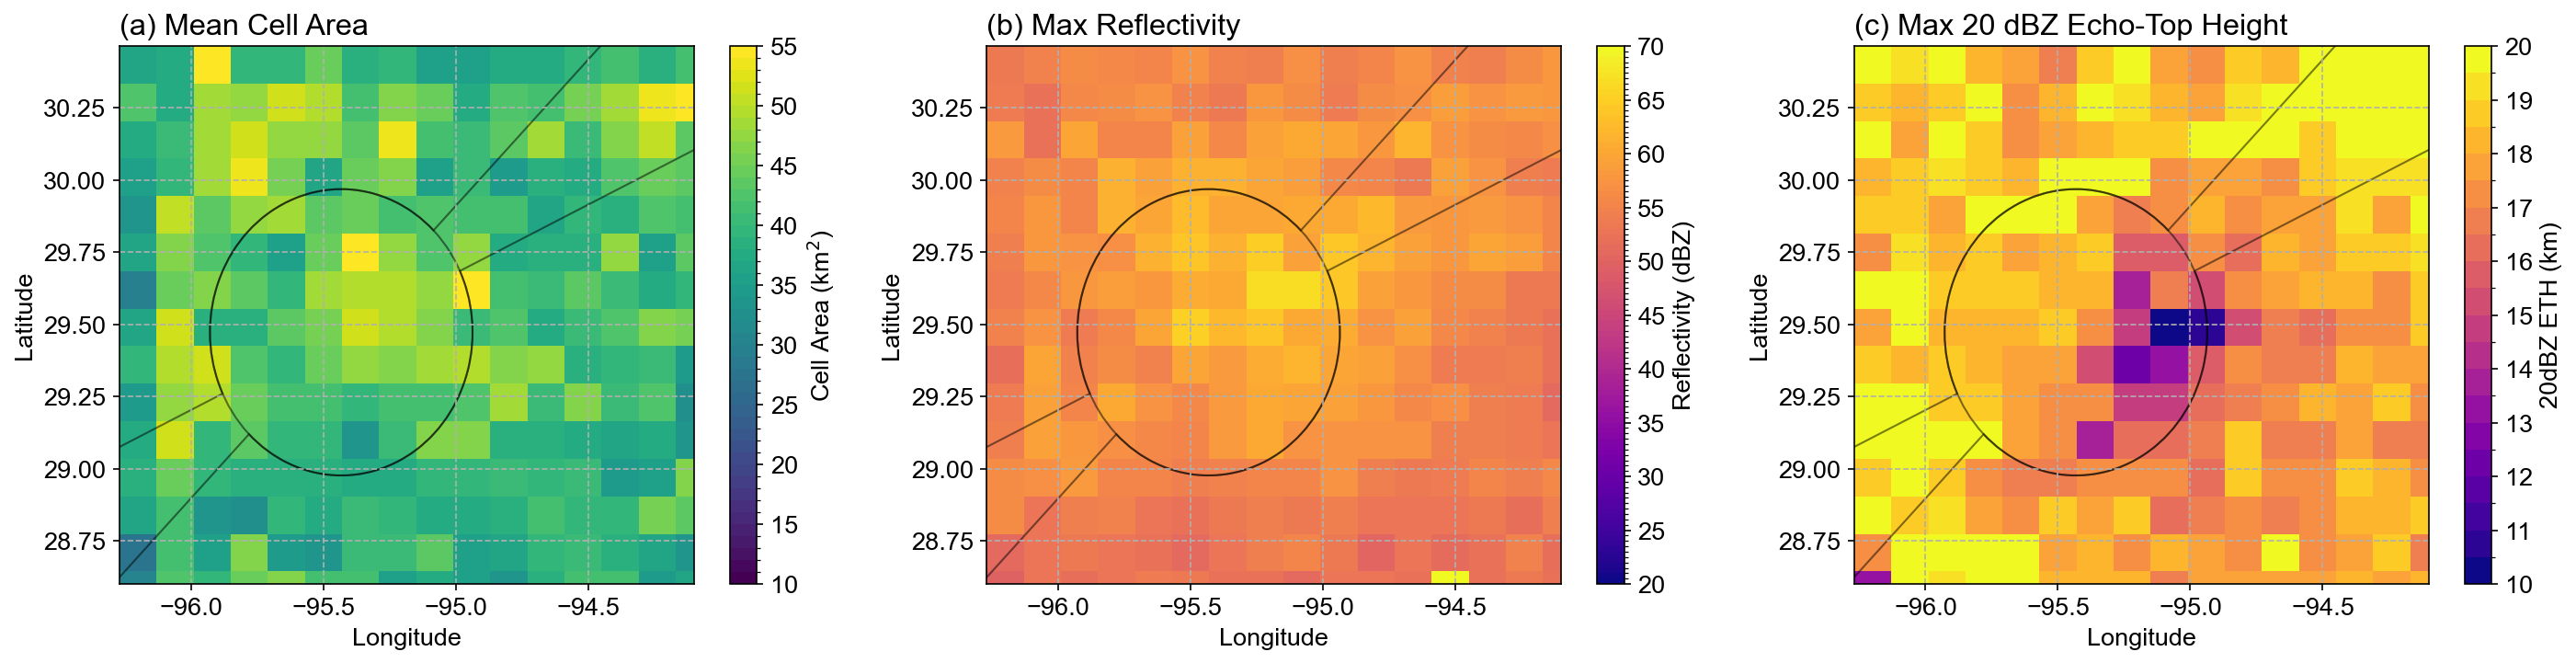

In [201]:
# Adjusted parameters based on the provided structure
dataarr = [Mean_Area_heatmap, Max_dbz_heatmap, Max_ETH20_heatmap]  # Your data arrays
levels = [np.arange(10, 55.1, 1), np.arange(20, 70.1, 0.5), np.arange(10, 20.1, 0.5)]
cbticks = [np.arange(10, 60.1, 5), np.arange(20, 70.1, 5), np.arange(10, 20.1, 1)]  # Adjusted to match the number of heatmaps
cmaps = ['viridis', 'plasma', 'plasma']  # Flattened list
cmap_topo = ['Reds', 'Greens', 'Greens']  # Flattened list
titles = ['(a) Mean Cell Area', '(b) Max Reflectivity', '(c) Max 20 dBZ Echo-Top Height']  # Simplified titles
cblabels = ['Cell Area (km$^2$)', 'Reflectivity (dBZ)', '20dBZ ETH (km)']  # Flattened list
xlabels = ['Longitude', 'Longitude', 'Longitude']
ylabels = ['Latitude', 'Latitude', 'Latitude']
figname = 'your_figure_path.png'

# Example usage:
fig = plot_3heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, city_center, urban_radius,  cblabels, cbticks, titles, xlabels, ylabels, figname, eSDC=None)

In [202]:
len(Mean_Area_heatmap)

16

In [203]:
len(Max_dbz_heatmap)

16

# Separate tracks by start hour and count by locations

In [204]:
shour_nonsplit = start_hour[nonsplit]
start_lon_nonsplit = start_lon.values[nonsplit]
start_lat_nonsplit = start_lat.values[nonsplit]

ehour_nonmerge = end_hour[nonmerge]
end_lon_nonmerge = end_lon[nonmerge]
end_lat_nonmerge = end_lat[nonmerge]

# Get track start hours [UTC]
mask0 = np.logical_and(shour_nonsplit >= 0, shour_nonsplit < 3)
mask3 = np.logical_and(shour_nonsplit >= 3, shour_nonsplit < 6)
mask6 = np.logical_and(shour_nonsplit >= 6, shour_nonsplit < 9)
mask9 = np.logical_and(shour_nonsplit >= 9, shour_nonsplit < 12)
mask12 = np.logical_and(shour_nonsplit >= 12, shour_nonsplit < 15)
mask15 = np.logical_and(shour_nonsplit >= 15, shour_nonsplit < 18)
mask18 = np.logical_and(shour_nonsplit >= 18, shour_nonsplit < 21)
mask21 = np.logical_and(shour_nonsplit >= 21, shour_nonsplit < 24)

# Get track start location by diurnal timing
bins = [10, 10]
ranges = [[minlat+buffer,maxlat-buffer], [minlon+buffer,maxlon-buffer]]
hist2d_startloc_nonsplit_hr0, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask0], start_lon_nonsplit[mask0], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr3, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask3], start_lon_nonsplit[mask3], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr6, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask6], start_lon_nonsplit[mask6], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr9, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask9], start_lon_nonsplit[mask9], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr12, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask12], start_lon_nonsplit[mask12], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr15, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask15], start_lon_nonsplit[mask15], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr18, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask18], start_lon_nonsplit[mask18], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr21, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask21], start_lon_nonsplit[mask21], bins=bins, range=ranges)


In [205]:
# Get track start hours [UTC]
mask0 = np.logical_and(start_hour >= 0, start_hour < 3)
mask3 = np.logical_and(start_hour >= 3, start_hour < 6)
mask6 = np.logical_and(start_hour >= 6, start_hour < 9)
mask9 = np.logical_and(start_hour >= 9, start_hour < 12)
mask12 = np.logical_and(start_hour >= 12, start_hour < 15)
mask15 = np.logical_and(start_hour >= 15, start_hour < 18)
mask18 = np.logical_and(start_hour >= 18, start_hour < 21)
mask21 = np.logical_and(start_hour >= 21, start_hour < 24)

# Get track start location by diurnal timing
bins = [12, 12]
ranges = [[minlat+buffer,maxlat-buffer], [minlon+buffer,maxlon-buffer]]
hist2d_startloc_hr0, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask0], start_lon.values[mask0], bins=bins, range=ranges)
hist2d_startloc_hr3, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask3], start_lon.values[mask3], bins=bins, range=ranges)
hist2d_startloc_hr6, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask6], start_lon.values[mask6], bins=bins, range=ranges)
hist2d_startloc_hr9, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask9], start_lon.values[mask9], bins=bins, range=ranges)
hist2d_startloc_hr12, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask12], start_lon.values[mask12], bins=bins, range=ranges)
hist2d_startloc_hr15, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask15], start_lon.values[mask15], bins=bins, range=ranges)
hist2d_startloc_hr18, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask18], start_lon.values[mask18], bins=bins, range=ranges)
hist2d_startloc_hr21, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask21], start_lon.values[mask21], bins=bins, range=ranges)


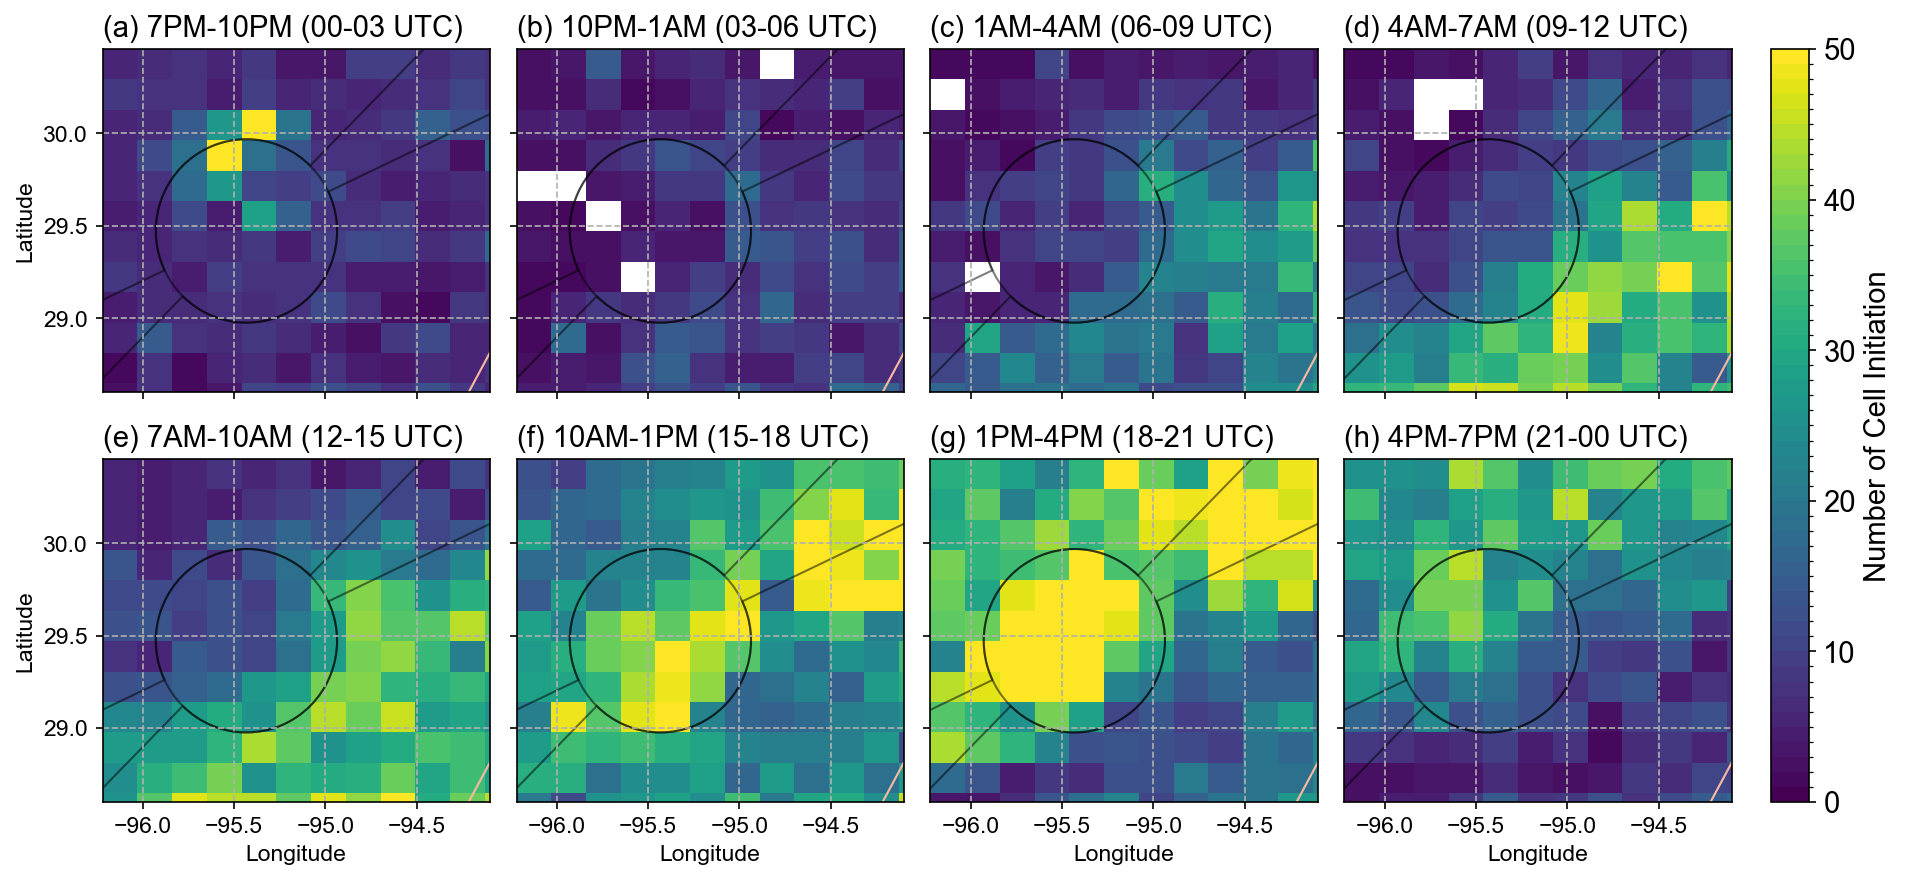

In [206]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Arial'
fig, axs = plt.subplots(2, 4, figsize=[14,6], dpi=150)
   
dataarr = [[hist2d_startloc_hr0, hist2d_startloc_hr3, hist2d_startloc_hr6, hist2d_startloc_hr9],
    [hist2d_startloc_hr12, hist2d_startloc_hr15, hist2d_startloc_hr18, hist2d_startloc_hr21]
           ]
lonarr = xbins_c
latarr = ybins_c
levels = np.arange(0, 50.1, 1)
cbticks = np.arange(0, 50.1, 10)
titles = [    ["(a) 7PM-10PM (00-03 UTC)", "(b) 10PM-1AM (03-06 UTC)", "(c) 1AM-4AM (06-09 UTC)", "(d) 4AM-7AM (09-12 UTC)"],
    ["(e) 7AM-10AM (12-15 UTC)", "(f) 10AM-1PM (15-18 UTC)", "(g) 1PM-4PM (18-21 UTC)", "(h) 4PM-7PM (21-00 UTC)"]
]


cblabel = 'Number of Cell Initiation'

cmap = plt.get_cmap('viridis')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

xlabels = [['','','','',], ['Longitude','Longitude','Longitude','Longitude']]
ylabels = [['Latitude','','',''], ['Latitude','','','']]

marker_style = dict(color='k', linestyle='none', marker='o', markersize=10, markerfacecolor='red')
topo_levs = [20,40,60,80,100]
cmap_topo = 'Reds'

pcm_save = []

for row in range(2):
    for col in range(4):
        ax1 = axs[row, col]
        Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
        pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels[row][col])
        ax1.set_ylabel(ylabels[row][col])
        ax1.set_title(titles[row][col], loc='left', fontsize=14)
        ax1.set_xlim(np.min(lonarr), -94.1)
        ax1.set_ylim(28.6, np.max(latarr))
        #ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
        #ax1.set_yticks(np.arange(-33, maxlat, 0.5))
        ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1)
        #ax1.plot(radar_lon, radar_lat, **marker_style)
        #ax1.text(radar_lon+0.1, radar_lat, 'AMF', fontsize=13, color='red')
        ax1.grid(ls='--')
        if (row == 0):
            ax1.xaxis.set_ticklabels([])
            if (col == 0):
                # Legend for terrain
                custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.8), lw=2)]
                # ax1.legend(custom_lines, ['Terrain'], loc='upper right')
        if (col > 0):
            ax1.yaxis.set_ticklabels([])
        
        # Urban and impact area plotting
            city_center = city_center
        urban_radius = urban_radius
        downwind_start = 100
        downwind_end = 100
        sector_angle = 160  # in degrees
        mean_wind_angle = 125.37  # in degrees
        urban_circle = patches.Circle(city_center, urban_radius, fill=False, alpha=0.5)
        ax1.add_patch(urban_circle)
        downwind_end_scaled = downwind_end * urban_radius / 25
        # Adjust the following patches as necessary to fit your plotting context
        upwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle+180-(sector_angle/2), mean_wind_angle+180+(sector_angle/2), 
                             width=downwind_end_scaled - urban_radius, alpha=0.5, fill=False)
        ax1.add_patch(upwind_wedge)

        downwind_wedge = patches.Wedge(city_center, downwind_end_scaled, mean_wind_angle-(sector_angle/2), mean_wind_angle+(sector_angle/2), width=downwind_end_scaled - urban_radius, fill=False, alpha=0.5)
        ax1.add_patch(downwind_wedge)
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

# Adjust the layout before plotting colorbar
fig.tight_layout()

# Plot 1 color for the whole figure
cbar = fig.colorbar(pcm_save[0], ax=axs[:, :], shrink=1, pad=0.02)
cbar.set_ticks(cbticks)
cbar.set_label(label=cblabel, fontsize=14)
cbar.ax.tick_params(labelsize=14)

# figname = f'{figdir}celltrack_start_loc_diurnal_cycle_0.2deg_2x4.png'
# fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)


## Extract storms in the urban area

In [207]:
# Initiation at urban area
def lat_lon_to_cartesian(lat, lon, R=6371):
    x = R * np.radians(lon)
    y = R * np.radians(lat)
    return x, y

center_lat, center_lon, radius = city_center[1], city_center[0], 76.35
center_x, center_y = lat_lon_to_cartesian(center_lat, center_lon)
storm_x, storm_y = lat_lon_to_cartesian(start_lat, start_lon)
distances = np.sqrt((storm_x - center_x)**2 + (storm_y - center_y)**2)
storms_in_circle = start_hour[distances <= radius]
hist_storms_in_circle, bins = np.histogram(storms_in_circle, bins=hour_bin, range=(0, 24), density=False)
hist_storms_in_circle_LT = np.roll(hist_storms_in_circle, -5)

# Fraction of E.SDC tracks to all tracks
hist_storms_in_circle_LT_frac = 100 * (hist_storms_in_circle_LT / hist_starthour_LT)

## Extract storms in the upwind and downwind areas

In [208]:
storm_points = [Point(lon, lat) for lon, lat in zip(start_lon, start_lat)]

# Filter storms in the downwind wedge
storms_in_downwind_wedge = [start_hour[i] for i, point in enumerate(storm_points) if clipped_downwind_wedge.contains(point)]
storms_in_downwind_wedge = xr.concat(storms_in_downwind_wedge, dim='tracks')
hist_storms_in_downwind_wedge, bins = np.histogram(storms_in_downwind_wedge, bins=hour_bin, range=(0, 24), density=False)
hist_storms_in_downwind_wedge_LT = np.roll(hist_storms_in_downwind_wedge, -5)
hist_storms_in_downwind_wedge_LT_frac = 100 * (hist_storms_in_downwind_wedge_LT / hist_starthour_LT)


# Filter storms in the upwind wedge
storms_in_upwind_wedge = [start_hour[i] for i, point in enumerate(storm_points) if clipped_upwind_wedge.contains(point)]
storms_in_upwind_wedge = xr.concat(storms_in_upwind_wedge, dim='tracks')
hist_storms_in_upwind_wedge, bins = np.histogram(storms_in_upwind_wedge, bins=hour_bin, range=(0, 24), density=False)
hist_storms_in_upwind_wedge_LT = np.roll(hist_storms_in_upwind_wedge, -5)
hist_storms_in_upwind_wedge_LT_frac = 100 * (hist_storms_in_upwind_wedge_LT / hist_starthour_LT)

## Calculate basic statistics for the urban region

In [209]:
circle = storms_in_circle.tracks.values
stats_circle = stats.sel(tracks=circle)
start_time_circle = stats_circle['start_basetime']
end_time_circle = stats_circle['end_basetime']
start_hour_circle = start_time_circle.dt.hour
end_hour_circle = end_time_circle.dt.hour
cell_lon_circle = stats_circle['cell_meanlon']
cell_lat_circle = stats_circle['cell_meanlat']
cell_area_circle = stats_circle['cell_area']
maxrange_flag_circle = stats_circle['maxrange_flag']
maxdbz_circle = stats_circle['max_dbz']
eth20_circle = stats_circle['maxETH_20dbz']

cell_diam_circle = 2 * np.sqrt(cell_area_circle / np.pi)
cell_diam_mean_circle = cell_diam_circle.mean(dim='times')
cell_area_mean_circle = cell_area_circle.mean(dim='times')
cell_eth20_mean_circle = eth20_circle.mean(dim='times')
cell_maxdbz_mean_circle = maxdbz_circle.mean(dim='times')


In [210]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_mean_hourbin_circle = []
cell_diam_mean_hourbin_circle = []
cell_eth20_mean_hourbin_circle = []
cell_maxdbz_mean_hourbin_circle = []
for ihour in range(24):
    cell_area_mean_hourbin_circle.append(np.log10(cell_area_mean_circle.where(start_hour_circle == ihour, drop=True)).values)
    cell_diam_mean_hourbin_circle.append(cell_diam_mean_circle.where(start_hour_circle == ihour, drop=True).values)
    cell_eth20_mean_hourbin_circle.append(cell_eth20_mean_circle.where((start_hour_circle == ihour) & (~np.isnan(cell_eth20_mean_circle)), drop=True).values)
    cell_maxdbz_mean_hourbin_circle.append(cell_maxdbz_mean_circle.where((start_hour_circle == ihour) & (~np.isnan(cell_maxdbz_mean_circle)), drop=True).values)
    

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_mean_hourbin_circle = np.array(cell_diam_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_diam_mean_hourbin_LT_circle = np.roll(cell_diam_mean_hourbin_circle, -5)
cell_area_mean_hourbin_circle = np.array(cell_area_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_area_mean_hourbin_LT_circle = np.roll(cell_area_mean_hourbin_circle, -5)
cell_eth20_mean_hourbin_circle = np.array(cell_eth20_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_eth20_mean_hourbin_LT_circle = np.roll(cell_eth20_mean_hourbin_circle, -5)
cell_maxdbz_mean_hourbin_circle = np.array(cell_maxdbz_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_maxdbz_mean_hourbin_LT_circle = np.roll(cell_maxdbz_mean_hourbin_circle, -5)

## Calculate basic statistics for the upwind region

In [211]:
upwind = storms_in_upwind_wedge.tracks.values
stats_upwind = stats.sel(tracks=upwind)
start_time_upwind = stats_upwind['start_basetime']
end_time_upwind = stats_upwind['end_basetime']
start_hour_upwind = start_time_upwind.dt.hour
end_hour_upwind = end_time_upwind.dt.hour
cell_lon_upwind = stats_upwind['cell_meanlon']
cell_lat_upwind = stats_upwind['cell_meanlat']
cell_area_upwind = stats_upwind['cell_area']
maxrange_flag_upwind = stats_upwind['maxrange_flag']
maxdbz_upwind = stats_upwind['max_dbz']
eth20_upwind = stats_upwind['maxETH_20dbz']

cell_diam_upwind = 2 * np.sqrt(cell_area_upwind / np.pi)
cell_diam_mean_upwind = cell_diam_upwind.mean(dim='times')
cell_area_mean_upwind = cell_area_upwind.mean(dim='times')
cell_eth20_mean_upwind = eth20_upwind.mean(dim='times')
cell_maxdbz_mean_upwind = maxdbz_upwind.mean(dim='times')


In [212]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_mean_hourbin_upwind = []
cell_diam_mean_hourbin_upwind = []
cell_eth20_mean_hourbin_upwind = []
cell_maxdbz_mean_hourbin_upwind = []
for ihour in range(24):
    cell_area_mean_hourbin_upwind.append(np.log10(cell_area_mean_upwind.where(start_hour_upwind == ihour, drop=True)).values)
    cell_diam_mean_hourbin_upwind.append(cell_diam_mean_upwind.where(start_hour_upwind == ihour, drop=True).values)
    cell_eth20_mean_hourbin_upwind.append(cell_eth20_mean_upwind.where((start_hour_upwind == ihour) & (~np.isnan(cell_eth20_mean_upwind)), drop=True).values)
    cell_maxdbz_mean_hourbin_upwind.append(cell_maxdbz_mean_upwind.where((start_hour_upwind == ihour) & (~np.isnan(cell_maxdbz_mean_upwind)), drop=True).values)
    

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_mean_hourbin_upwind = np.array(cell_diam_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_diam_mean_hourbin_LT_upwind = np.roll(cell_diam_mean_hourbin_upwind, -5)
cell_area_mean_hourbin_upwind = np.array(cell_area_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_area_mean_hourbin_LT_upwind = np.roll(cell_area_mean_hourbin_upwind, -5)
cell_eth20_mean_hourbin_upwind = np.array(cell_eth20_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_eth20_mean_hourbin_LT_upwind = np.roll(cell_eth20_mean_hourbin_upwind, -5)
cell_maxdbz_mean_hourbin_upwind = np.array(cell_maxdbz_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_maxdbz_mean_hourbin_LT_upwind = np.roll(cell_maxdbz_mean_hourbin_upwind, -5)

## Calculate basic statistics for the downwind region

In [213]:
downwind = storms_in_downwind_wedge.tracks.values
stats_downwind = stats.sel(tracks=downwind)
start_time_downwind = stats_downwind['start_basetime']
end_time_downwind = stats_downwind['end_basetime']
start_hour_downwind = start_time_downwind.dt.hour
end_hour_downwind = end_time_downwind.dt.hour
cell_lon_downwind = stats_downwind['cell_meanlon']
cell_lat_downwind = stats_downwind['cell_meanlat']
cell_area_downwind = stats_downwind['cell_area']
maxrange_flag_downwind = stats_downwind['maxrange_flag']
maxdbz_downwind = stats_downwind['max_dbz']
eth20_downwind = stats_downwind['maxETH_20dbz']

cell_diam_downwind = 2 * np.sqrt(cell_area_downwind / np.pi)
cell_diam_mean_downwind = cell_diam_downwind.mean(dim='times')
cell_area_mean_downwind = cell_area_downwind.mean(dim='times')
cell_eth20_mean_downwind = eth20_downwind.mean(dim='times')
cell_maxdbz_mean_downwind = maxdbz_downwind.mean(dim='times')


In [214]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_mean_hourbin_downwind = []
cell_diam_mean_hourbin_downwind = []
cell_eth20_mean_hourbin_downwind = []
cell_maxdbz_mean_hourbin_downwind = []
for ihour in range(24):
    cell_area_mean_hourbin_downwind.append(np.log10(cell_area_mean_downwind.where(start_hour_downwind == ihour, drop=True)).values)
    cell_diam_mean_hourbin_downwind.append(cell_diam_mean_downwind.where(start_hour_downwind == ihour, drop=True).values)
    cell_eth20_mean_hourbin_downwind.append(cell_eth20_mean_downwind.where((start_hour_downwind == ihour) & (~np.isnan(cell_eth20_mean_downwind)), drop=True).values)
    cell_maxdbz_mean_hourbin_downwind.append(cell_maxdbz_mean_downwind.where((start_hour_downwind == ihour) & (~np.isnan(cell_maxdbz_mean_downwind)), drop=True).values)
    

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_mean_hourbin_downwind = np.array(cell_diam_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_diam_mean_hourbin_LT_downwind = np.roll(cell_diam_mean_hourbin_downwind, -5)
cell_area_mean_hourbin_downwind = np.array(cell_area_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_area_mean_hourbin_LT_downwind = np.roll(cell_area_mean_hourbin_downwind, -5)
cell_eth20_mean_hourbin_downwind = np.array(cell_eth20_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_eth20_mean_hourbin_LT_downwind = np.roll(cell_eth20_mean_hourbin_downwind, -5)
cell_maxdbz_mean_hourbin_downwind = np.array(cell_maxdbz_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_maxdbz_mean_hourbin_LT_downwind = np.roll(cell_maxdbz_mean_hourbin_downwind, -5)

# Plot all three regions

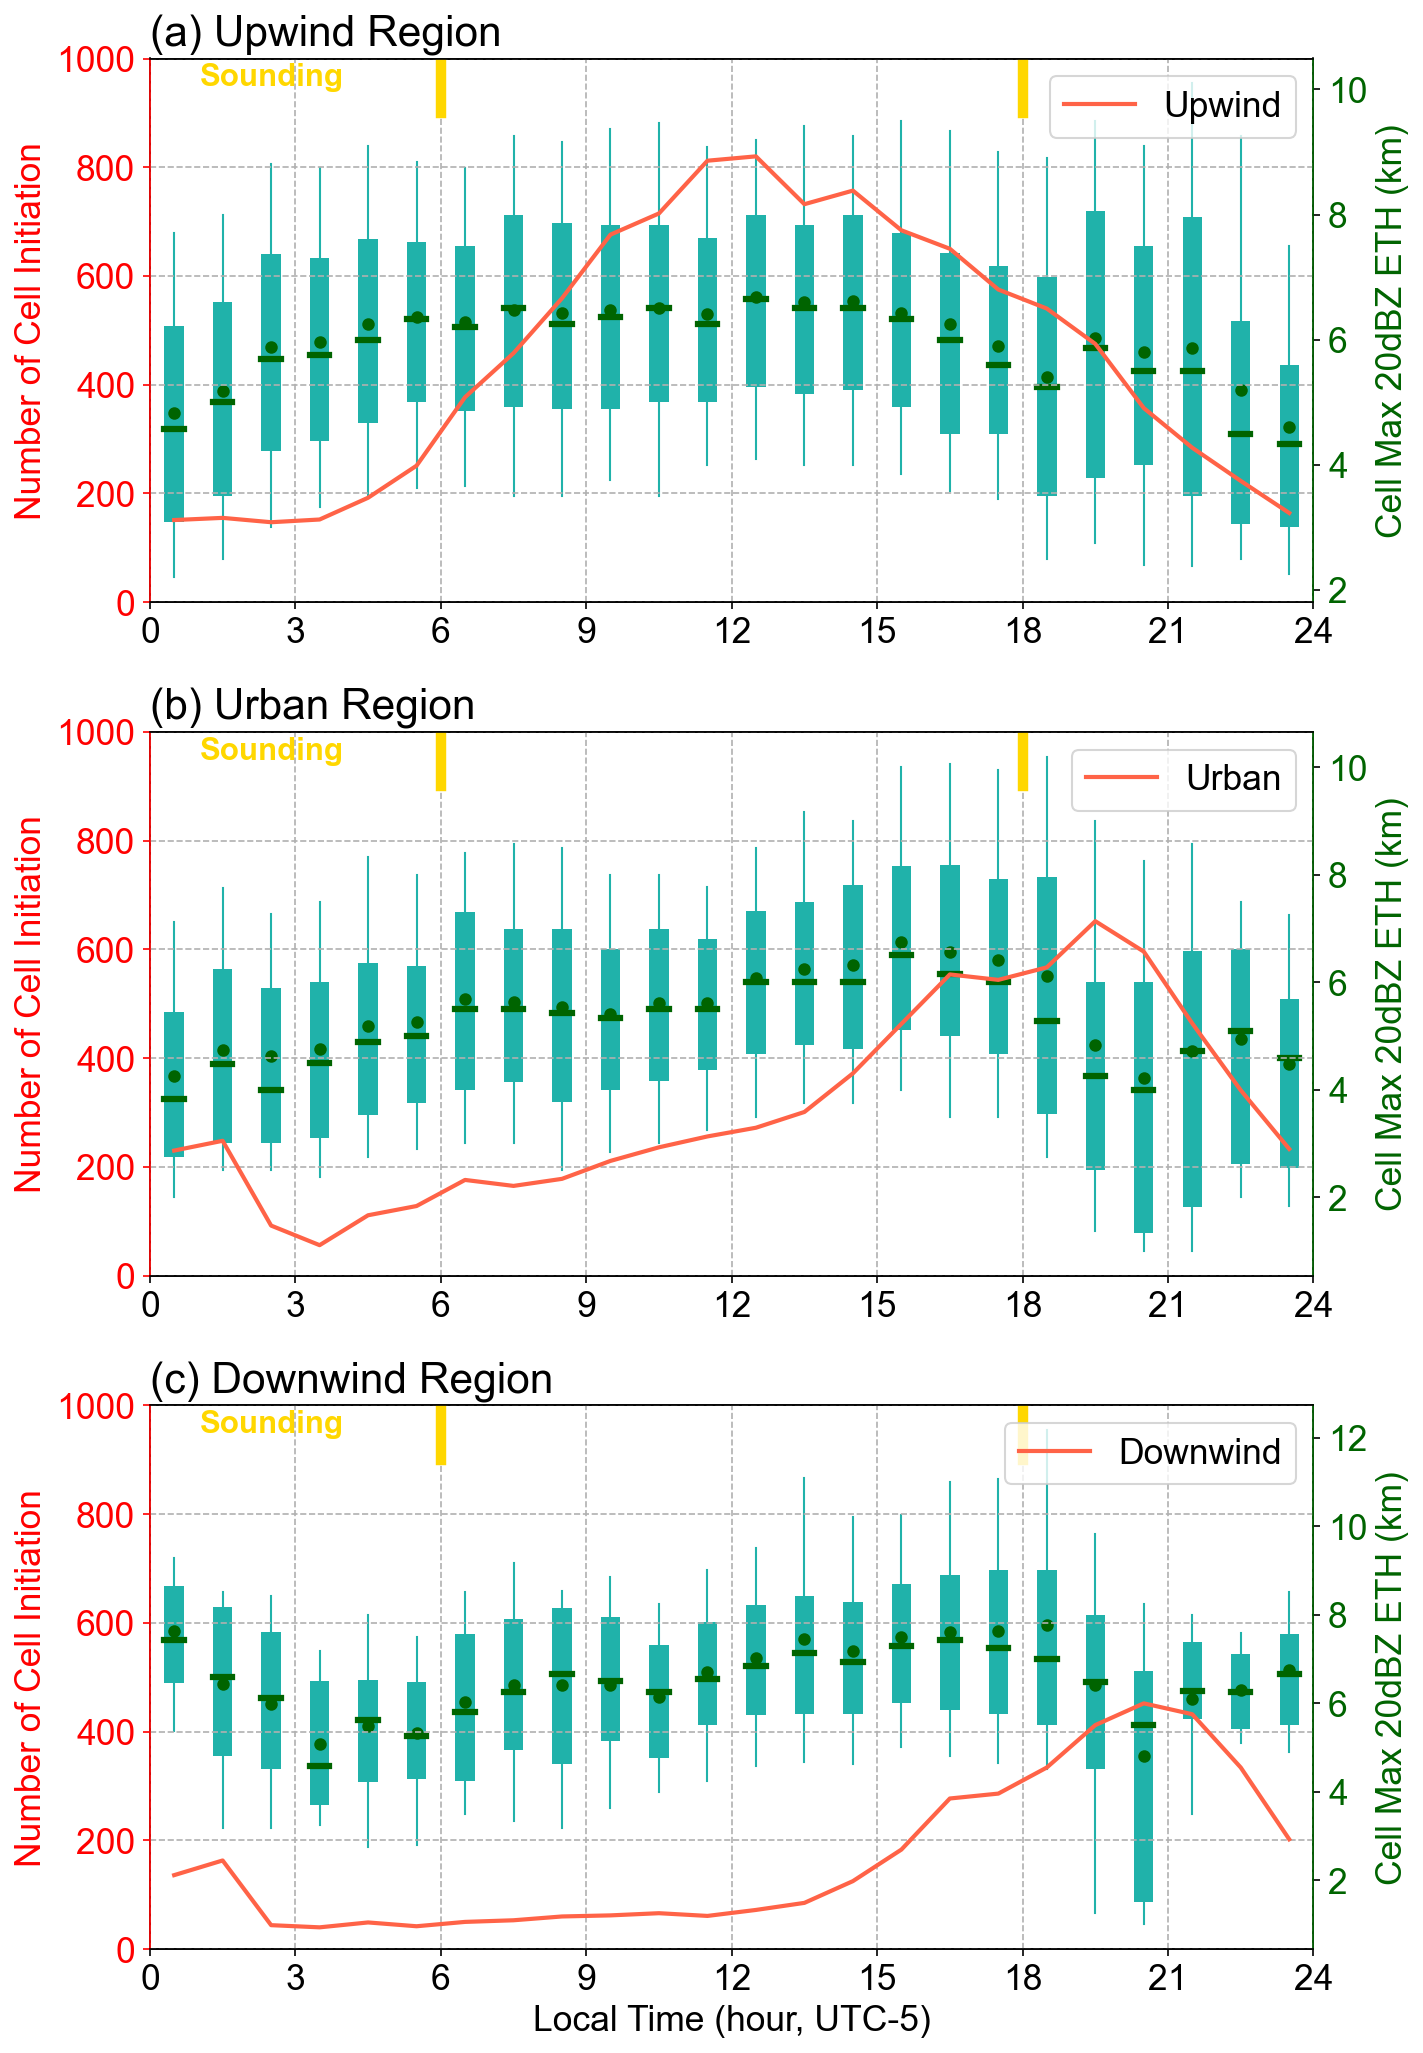

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

# Create a 3-row, 1-column figure
fig, axes = plt.subplots(3, 1, figsize=[10, 14], dpi=150)

# Times and hour bin values
sonde_times = [6, 18]
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

#-------------------------------------------
# First subplot (ax1)
ax1 = axes[0]
ax1.plot(hour_binv, hist_storms_in_upwind_wedge, color='tomato', lw=2, label='Upwind')
ax1.legend(loc='upper right', ncol=2)
ax1.grid(ls='--')
ax1.set_title('(a) Upwind Region', loc='left')
ax1.set_ylabel('Number of Cell Initiation')
ax1.set_ylim(0, 1000)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlim(0,24)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(4, 950, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='lightseagreen', alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color='lightseagreen')

ax1b = ax1.twinx()
bp1 = ax1b.boxplot(cell_eth20_mean_hourbin_LT_upwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1b.set_ylabel('Cell Max 20dBZ ETH (km)', color='darkgreen')
ax1b.tick_params(axis='y', labelcolor='darkgreen')
ax1.set_zorder(2)
ax1.patch.set_visible(False)
ax1.spines['left'].set_color('red')
ax1.spines['right'].set_color('darkgreen')

#-----------------------------------------------
# Second subplot (ax2)
ax2 = axes[1]
ax2.plot(hour_binv, hist_storms_in_circle, color='tomato', lw=2, label='Urban')
ax2.legend(loc='upper right', ncol=2)
ax2.grid(ls='--')
ax2.set_title('(b) Urban Region', loc='left')
ax2.set_ylabel('Number of Cell Initiation')
ax2.set_ylim(0, 1000)
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_xlim(0,24)
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(4, 950, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

ax2b = ax2.twinx()
bp2 = ax2b.boxplot(cell_eth20_mean_hourbin_LT_circle, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2b.set_ylabel('Cell Max 20dBZ ETH (km)', color='darkgreen')
ax2b.tick_params(axis='y', labelcolor='darkgreen')
ax2.set_zorder(2)
ax2.patch.set_visible(False)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('darkgreen')

#-----------------------------------------------
# Third subplot (ax3)
ax3 = axes[2]
ax3.plot(hour_binv, hist_storms_in_downwind_wedge, color='tomato', lw=2, label='Downwind')
ax3.legend(loc='upper right', ncol=2)
ax3.grid(ls='--')
ax3.set_title('(c) Downwind Region', loc='left')
ax3.set_ylabel('Number of Cell Initiation')
ax3.set_xlabel('Local Time (hour, UTC-5)')
ax3.set_ylim(0, 1000)
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_xlim(0,24)
ax3.yaxis.label.set_color('red')
ax3.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(4, 950, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

ax3b = ax3.twinx()
bp3 = ax3b.boxplot(cell_eth20_mean_hourbin_LT_downwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3b.set_ylabel('Cell Max 20dBZ ETH (km)', color='darkgreen')
ax3b.tick_params(axis='y', labelcolor='darkgreen')
ax3.set_zorder(2)
ax3.patch.set_visible(False)
ax3.spines['left'].set_color('red')
ax3.spines['right'].set_color('darkgreen')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()


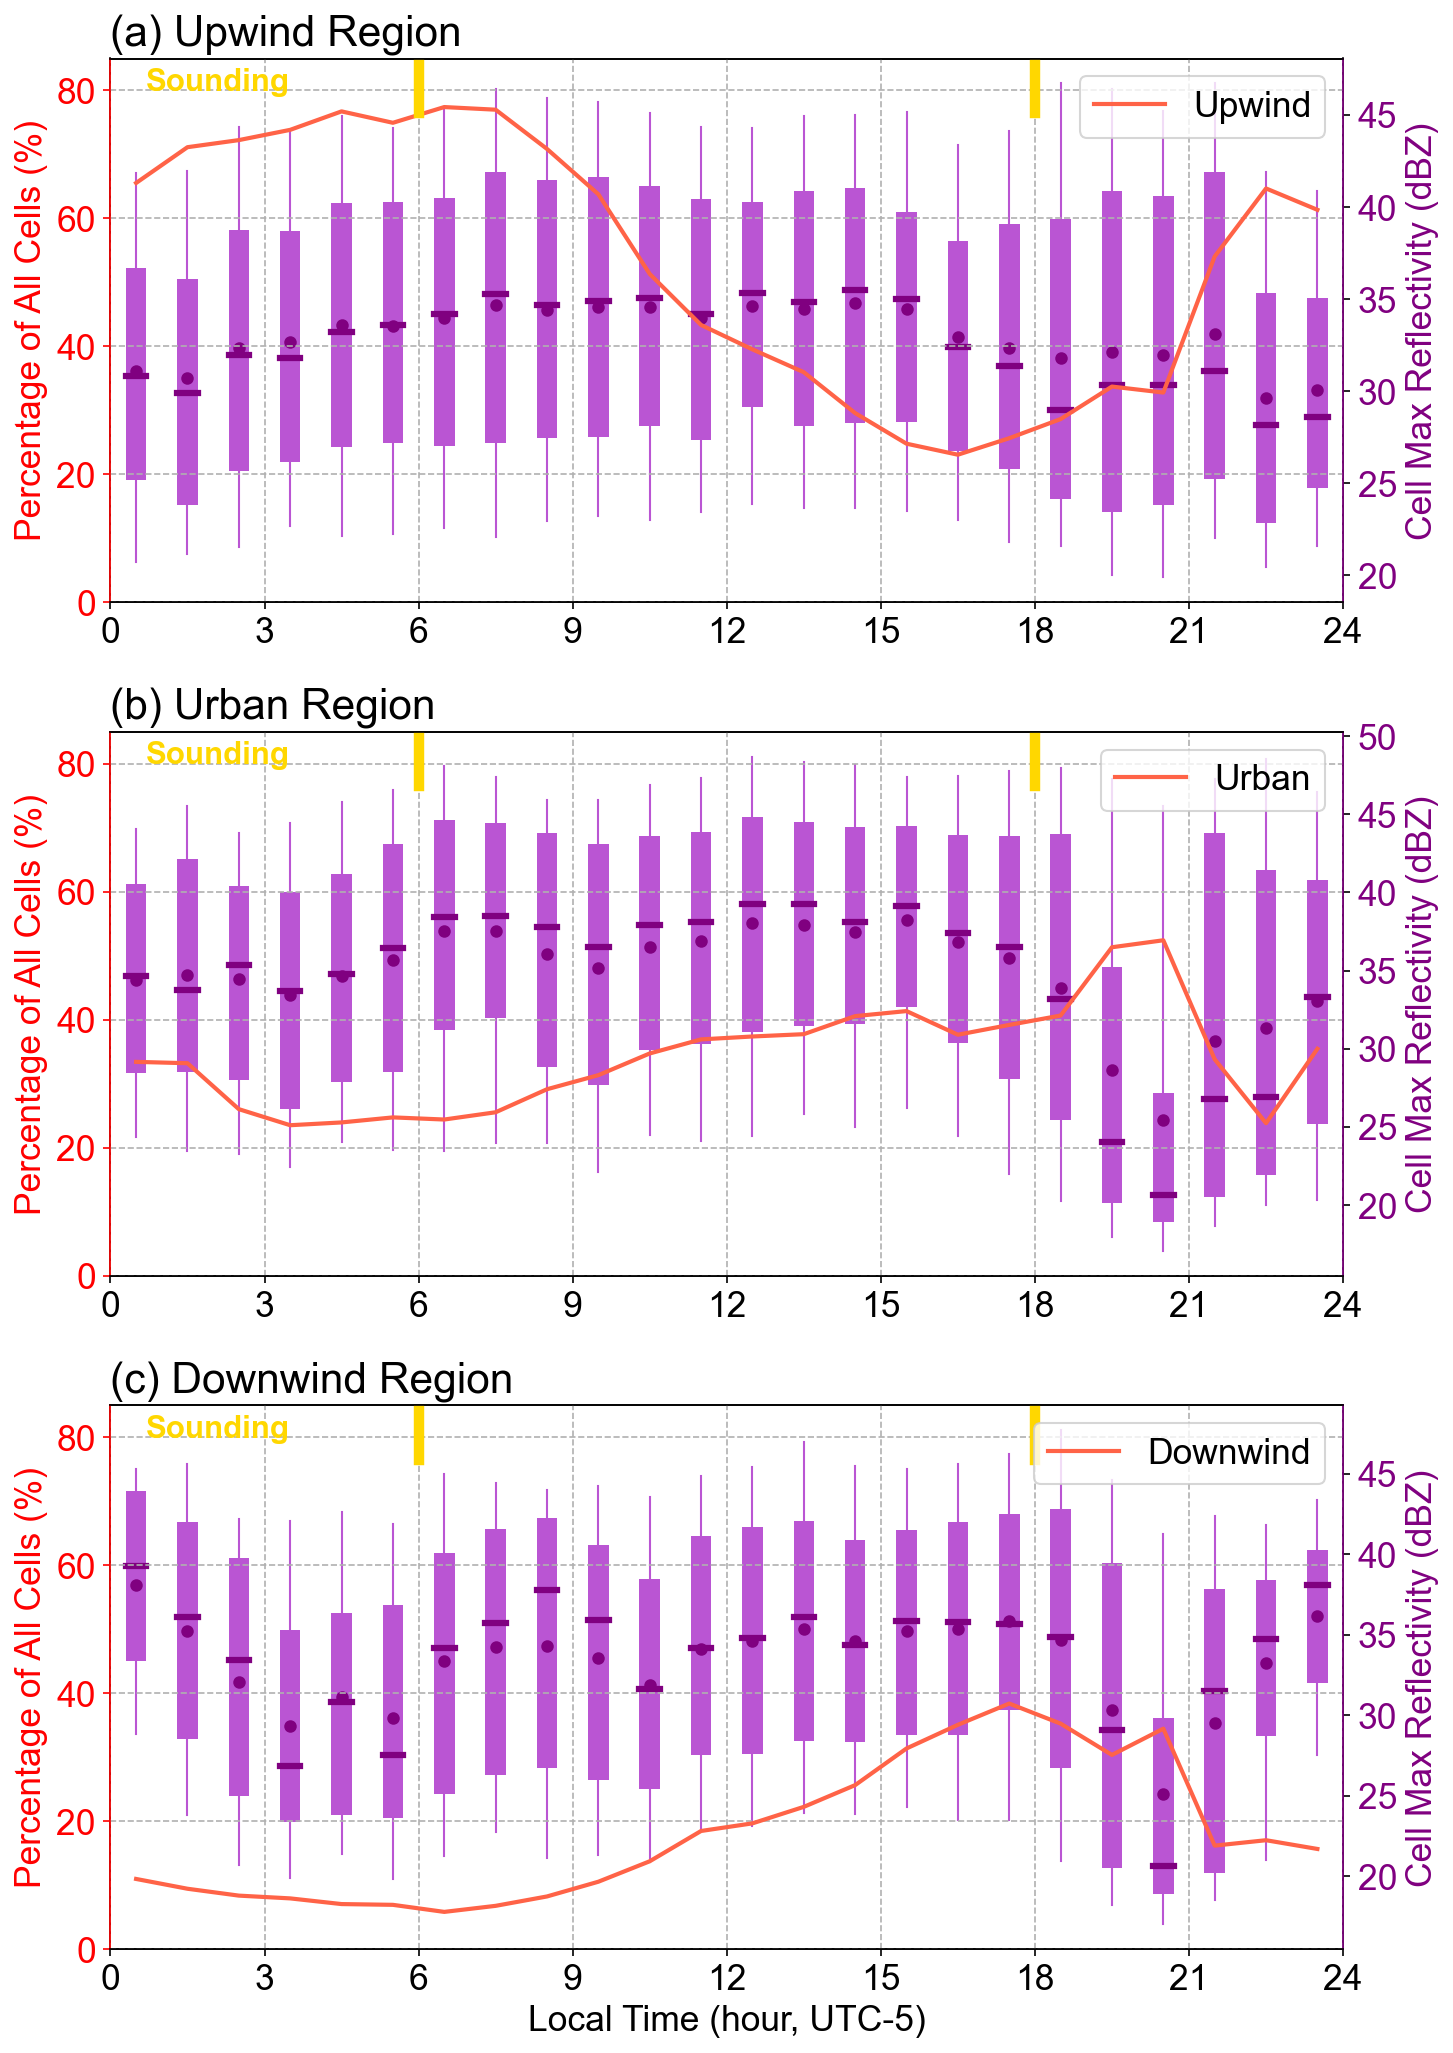

In [216]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

# Create a 3-row, 1-column figure
fig, axes = plt.subplots(3, 1, figsize=[10, 14], dpi=150)  # Change to 3 rows, 1 column
sonde_times = [6, 18]
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

#-------------------------------------------
# First subplot (ax1)
ax1 = axes[0]
ax1.plot(hour_binv, hist_storms_in_upwind_wedge_LT_frac, color='tomato', lw=2, label='Upwind')
ax1.legend(loc='upper right', ncol=2)
ax1.grid(ls='--')
ax1.set_title('(a) Upwind Region', loc='left')
ax1.set_ylabel('Percentage of All Cells (%)')
ax1.set_ylim(0, 85)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlim(0,24)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(3.5, 80, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings for ax1
barcolor = 'mediumorchid'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='purple')
meanpointprops_ = dict(marker='o', markeredgecolor='purple', markerfacecolor='purple', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

ax1b = ax1.twinx()
bp1 = ax1b.boxplot(cell_maxdbz_mean_hourbin_LT_upwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1b.set_ylabel('Cell Max Reflectivity (dBZ)', color='purple')
ax1b.tick_params(axis='y', labelcolor='purple')
ax1.set_zorder(2)
ax1.patch.set_visible(False)
ax1.spines['left'].set_color('red')
ax1.spines['right'].set_color('purple')

#-----------------------------------------------
# Second subplot (ax2)
ax2 = axes[1]
ax2.plot(hour_binv, hist_storms_in_circle_LT_frac, color='tomato', lw=2, label='Urban')
ax2.legend(loc='upper right', ncol=2)
ax2.grid(ls='--')
ax2.set_title('(b) Urban Region', loc='left')
ax2.set_ylabel('Percentage of All Cells (%)')
ax2.set_ylim(0, 85)
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_xlim(0,24)
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(3.5, 80, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings for ax2
ax2b = ax2.twinx()
bp2 = ax2b.boxplot(cell_maxdbz_mean_hourbin_LT_circle, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2b.set_ylabel('Cell Max Reflectivity (dBZ)', color='purple')
ax2b.tick_params(axis='y', labelcolor='purple')
ax2.set_zorder(2)
ax2.patch.set_visible(False)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('purple')

#-----------------------------------------------
# Third subplot (ax3)
ax3 = axes[2]
ax3.plot(hour_binv, hist_storms_in_downwind_wedge_LT_frac, color='tomato', lw=2, label='Downwind')
ax3.legend(loc='upper right', ncol=2)
ax3.grid(ls='--')
ax3.set_title('(c) Downwind Region', loc='left')
ax3.set_ylabel('Percentage of All Cells (%)')
ax3.set_xlabel('Local Time (hour, UTC-5)')
ax3.set_ylim(0, 85)
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_xlim(0,24)
ax3.yaxis.label.set_color('red')
ax3.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(3.5, 80, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings for ax3
ax3b = ax3.twinx()
bp3 = ax3b.boxplot(cell_maxdbz_mean_hourbin_LT_downwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3b.set_ylabel('Cell Max Reflectivity (dBZ)', color='purple')
ax3b.tick_params(axis='y', labelcolor='purple')
ax3.set_zorder(2)
ax3.patch.set_visible(False)
ax3.spines['left'].set_color('red')
ax3.spines['right'].set_color('purple')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()

In [217]:
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

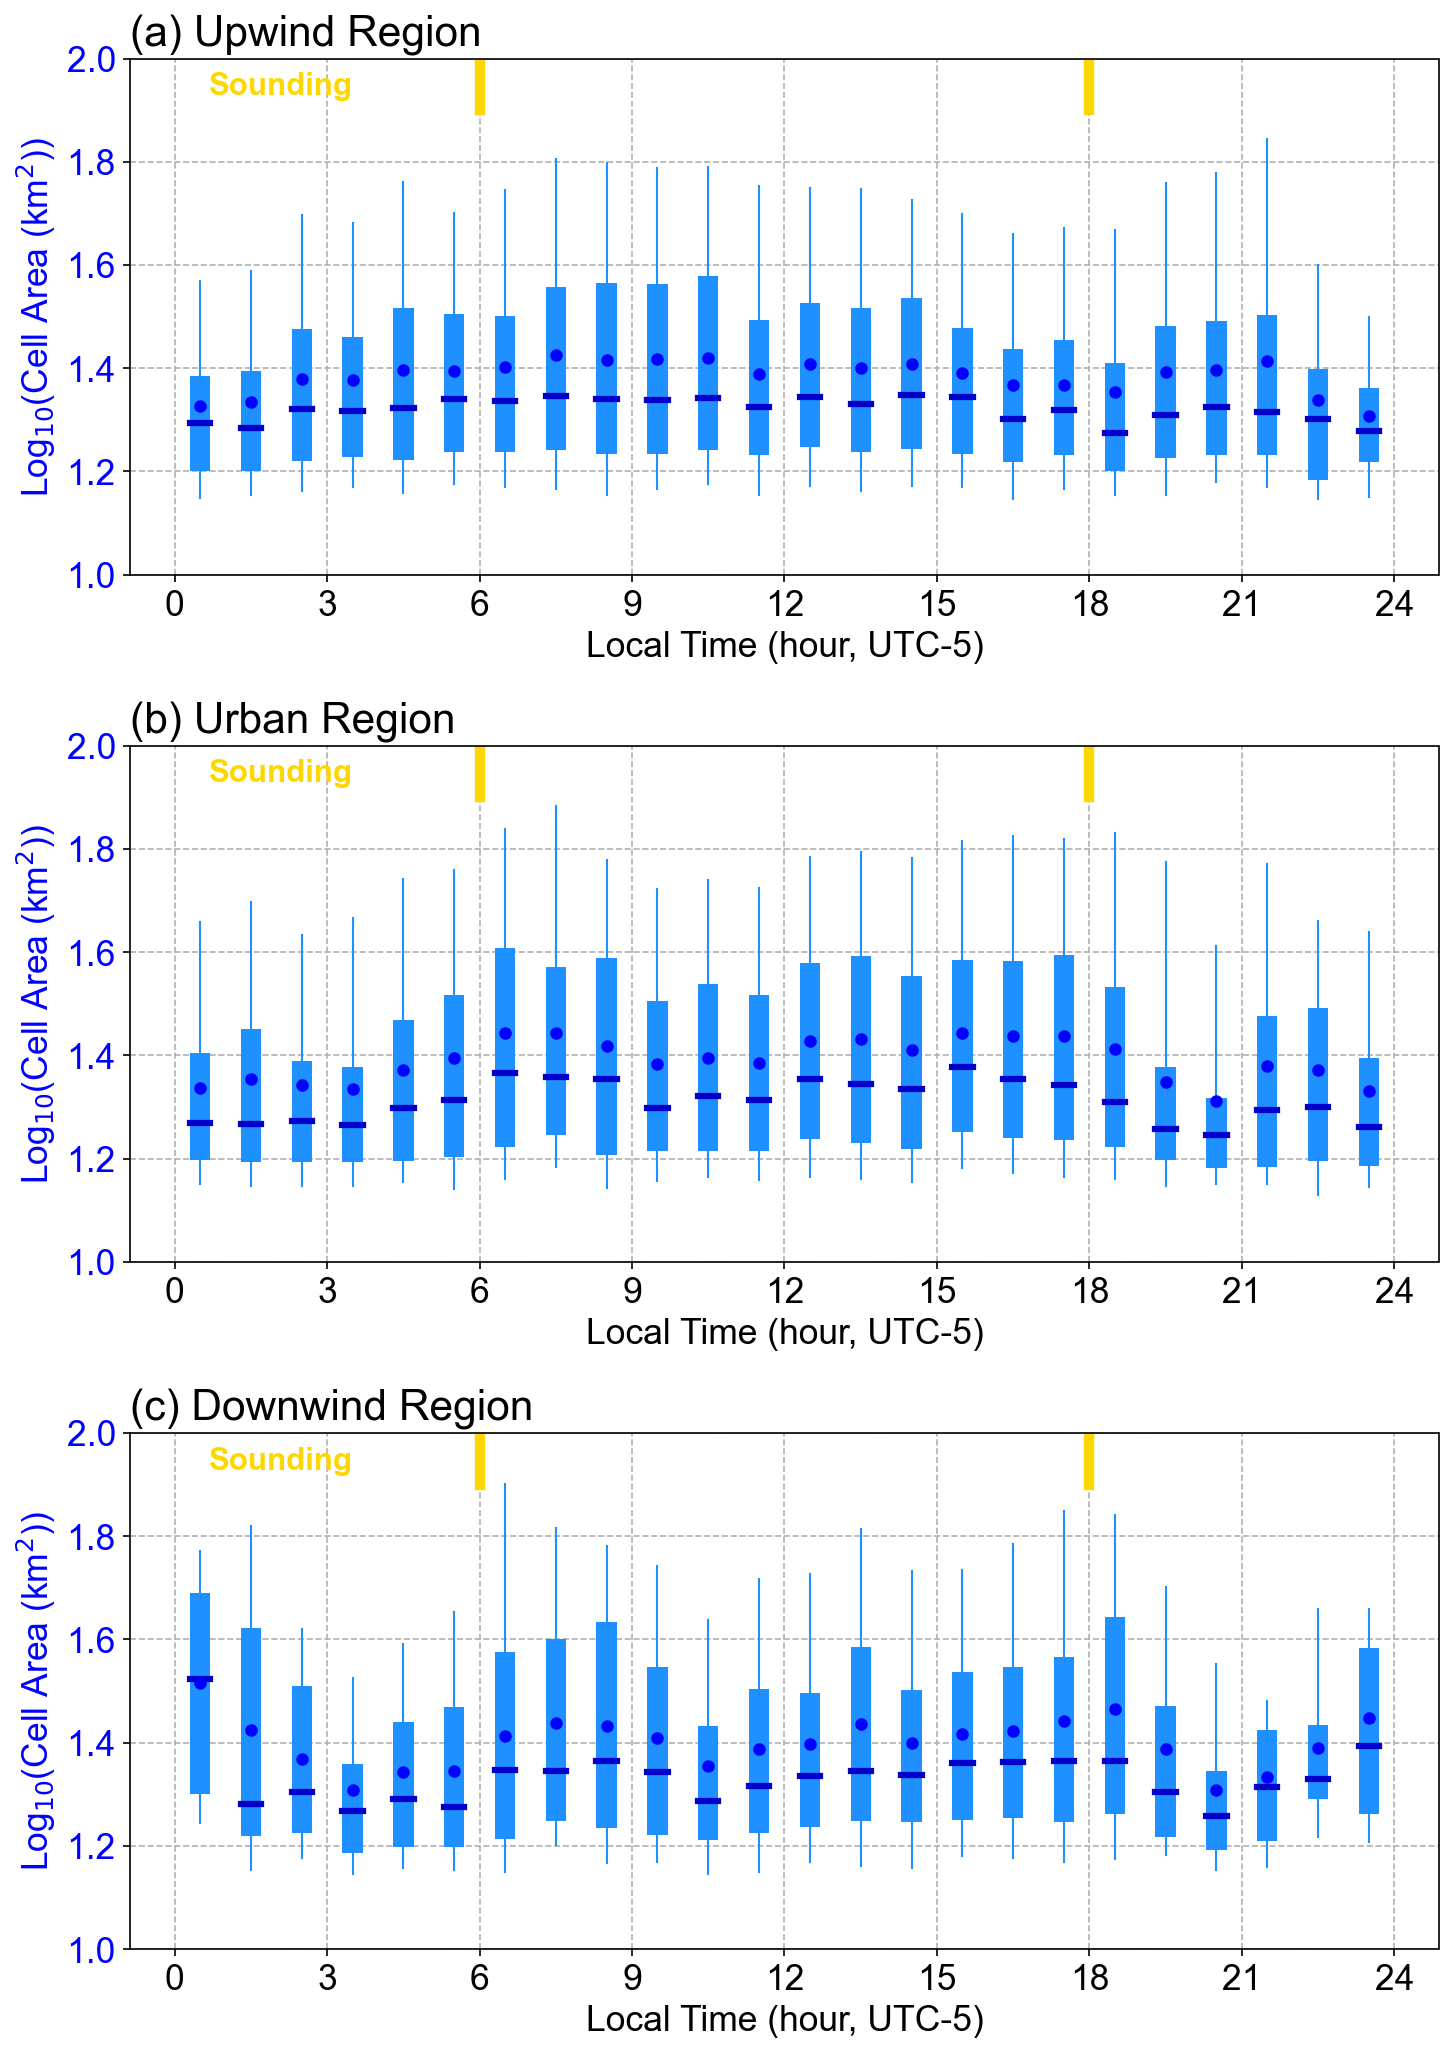

In [218]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

# Create a 3-row, 1-column figure
fig, axes = plt.subplots(3, 1, figsize=[10, 14], dpi=150)
sonde_times = [6, 18]
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

# Boxplot settings
barcolor = 'mediumorchid'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='dodgerblue', alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

# First subplot
ax1 = axes[0]
bp1 = ax1.boxplot(cell_area_mean_hourbin_LT_upwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1.set_ylabel('Log$_{10}$(Cell Area (km$^2$))', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(ls='--')
ax1.set_title('(a) Upwind Region', loc='left')
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlabel('Local Time (hour, UTC-5)')
ax1.set_ylim([1, 2.0])  # Adjust the limits as needed
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(3.5, 1.93, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Second subplot
ax2 = axes[1]
bp2 = ax2.boxplot(cell_area_mean_hourbin_LT_circle, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2.set_ylabel('Log$_{10}$(Cell Area (km$^2$))', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(ls='--')
ax2.set_title('(b) Urban Region', loc='left')
ax2.set_xlabel('Local Time (hour, UTC-5)')
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_ylim([1, 2.0])  # Adjust the limits as needed
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(3.5, 1.93, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Third subplot
ax3 = axes[2]
bp3 = ax3.boxplot(cell_area_mean_hourbin_LT_downwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3.set_ylabel('Log$_{10}$(Cell Area (km$^2$))', color='blue')
ax3.tick_params(axis='y', labelcolor='blue')
ax3.set_title('(c) Downwind Region', loc='left')
ax3.grid(ls='--')
ax3.set_xlabel('Local Time (hour, UTC-5)')
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_ylim([1, 2.0])  # Adjust the limits as needed
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(3.5, 1.93, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()


## Store the data

In [219]:
%store stats_downwind stats_upwind stats_circle

Stored 'stats_downwind' (Dataset)
Stored 'stats_upwind' (Dataset)
Stored 'stats_circle' (Dataset)


In [220]:
%store storms_in_upwind_wedge storms_in_circle storms_in_downwind_wedge

Stored 'storms_in_upwind_wedge' (DataArray)
Stored 'storms_in_circle' (DataArray)
Stored 'storms_in_downwind_wedge' (DataArray)
